# ECON 1923 CPI Project
## Created by: Gloria Dou, Peter Martin, and Kavya Singh

## 2 Definition of the Index
### 2.1 Items and weights

Products, services and their mix should be decided. Your basket must include at least 8 ingredients. Your choice should be justified. Use the online and other resources to build a reasonable basket of goods that represents, in your opinion, students. There are no correct or incorrect answers, I am looking for a well justified answer.

### 2.2 Locations and weights
The locations where these prices are measured. List at least three locations based on where the team members either live now, lived in the past, or want to live in the future.2 Choose weights for these locations according to your liking.

### 2.3 Finalizing the basket
Combining the choices of items and locations, find all the series names assign a weight for each series that combines the weights that you chose for the items and the weights you chose for the locations.

https://docs.google.com/document/d/1Rb8_QNXB3ybjHzDLKQBadFX2rS7RIILdCIdtplUyxg4/edit

- Everyone’s github User ID:
    - Kavya: kavyas01
    - Gloria: GloDDD
    - Peter: mpaertteirn

- Group of products, services, etc. that students would use (minimum 8): Click [here](https://www.bls.gov/news.release/cpi.t07.htm#cpipress7.f.4) to get a better understanding of what falls under each item group **We might want to reweight the items based on** [this](https://www.bls.gov/cex/tables/cross-tab/mean/reference-person-age-by-income-under-25-2020.pdf)
    - Meats, poultry, fish, and eggs (SAF112) [0.0395]
    - Fruits and Vegetables (SAF113) [0.0363]
    - Nonalcoholic beverages and beverage materials	(SAF114) [0.0193] 
    - Alcoholic beverages (SAF116) [0.0198] 
    - Apparel (SAA) [0.0907] 
    - Education and communication commodities (SAEC) [0.1869] 
    - Recreation (SAR) [0.0928] 
    - Rent of Primary  Residence (SEHA) [0.5146]

- Three locations: *I looked of region demographics on Pitt students, selected the three largest region by percentage, and then normalized them to equal 1.*
    - Mid Atlantic 0120 (NJ, NY, PA) [.8474]
    - South Atlantic 0350 (DC, DE, FL, GA, MD, NC, SC, VA, WV) [.0904]
    - East North Central 0230 (IL, IN, MI, OH, WI) [.0622]

In [1]:
# Importing packages
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt

# NOTE: Be sure that the python function is in the same folder, otherwise use relative address paths
%run APIkeys.py 
key = os.environ['BLS_API_key']

In [2]:
#This is a code to just make the basket array more easily updatable if needed
Base_ID = 'CUUR'

           #MidAtl  SoAtl   ENC
Area_ID = ['0120', '0350', '0230']
Area_Wt = (0.8474, 0.0904, .0622) #Area Weights
if round(sum(Area_Wt),3) !=1: #Check for weights to sum 1.0
    print('Warning: Area Weights do not equal to 1!')

Area_df = pd.DataFrame(data= {'ID' : Area_ID, 'Wt' : Area_Wt}) #dataframe for input in CPI function
Area_df.rename(index={0:'MidAtl', 1:'SoAtl', 2:'ENC'}, inplace=True)

           #Meat.     F&V.      Bevs.     Alc.      Apprl.  Ed&Com  Rec.    Rent
Item_ID = ['SAF112', 'SAF113', 'SAF114', 'SAF116', 'SAA' , 'SAEC', 'SAR' , 'SEHA']
Item_Wt = (0.0395  , 0.0363  , 0.0193  , 0.0198  , 0.0907, 0.1869, 0.0928, 0.5146) #Item Weights
Item_df = pd.DataFrame(data= {'ID' : Item_ID, 'Wt' : Item_Wt}) #dataframe for input in CPI function
if round(sum(Item_Wt),3) !=1:#Check for weights to sum 1.0
    print('Warning: Item Weights do not equal to 1!')
    print(sum(Item_Wt))

basket = ['CUUR0000SA0'] #General CPI ID in last, which we add other series IDs to
for i in Area_df['ID']:
    for j in Item_df['ID']:
        basket.append(Base_ID+i+j)

## 3 Downloading the data
### 3.1 Refine the basket
First, verify that the series you created in the previous section exist in the BLS’ API. If some items do not exist, take them out and re-weight. If a certain location produces all the missing series, replace that location with a bigger or more general location.
After you made all the changes and adjustments, state the final basket and the weights for each item in the basket. Table format will be great here.

### 3.2 Downloading
Make an API call to download the data for the basket you created. I ask that you have data for the last 5 years: January 2017 to January 2022. Make sure your API call retrieves data for this range.
    Include the general CPI (CUUR0000SA0) in your API call.
    Question: Are all the series you downloaded in a monthly frequency? If not, how can you fix that (i.e. interpolate).

In [3]:
def multiSeriesV4(varList,myKey):
    # Input: varList = a list of strings containing the series names
    # Input: myKey =  a string containing your BLS API key
    # Output: new_df = a data frame containing the data collected
    
    base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'  #this will not change
    headers = {'Content-type': 'application/json'}  #This will not changed !

    parameters = {
        "seriesid":varList,
        "startyear":"2017", 
        "endyear":"2022",
        "catalog":True, 
        "calculations":False, 
        "annualaverage":False,
        "aspects":False,
        "registrationkey": myKey 
     }

    data = json.dumps(parameters) #this converts the Python dictionary into a JSON format
    
    p = requests.post(base_url, data=data, headers=headers)
    json_data = json.loads(p.text)
    
    n = len(varList) #number of series requested
    
    new_df = pd.DataFrame(columns=['year', 'period'])
    for item in range(n):
        l = len(json_data['Results']['series'][item]['data']) #length of the list
        if l == 0:
            print('Series ',varList[item],' does not exist')
        else:
            
            print('Series ',varList[item],' exists with ',l,' observations')
            d = json_data['Results']['series'][item]['data']
            current_df = pd.DataFrame(data=d)
            current_df = current_df[["year","period","value"]]
            current_df = current_df.rename(columns = {"value":basket[item]})
            new_df = new_df.merge(current_df, on = ['year','period'],how='outer')
    
    return new_df

In [4]:
data = multiSeriesV4(basket,key)

Series  CUUR0000SA0  exists with  61  observations
Series  CUUR0120SAF112  exists with  50  observations
Series  CUUR0120SAF113  exists with  50  observations
Series  CUUR0120SAF114  exists with  50  observations
Series  CUUR0120SAF116  exists with  50  observations
Series  CUUR0120SAA  exists with  50  observations
Series  CUUR0120SAEC  exists with  50  observations
Series  CUUR0120SAR  exists with  50  observations
Series  CUUR0120SEHA  exists with  50  observations
Series  CUUR0350SAF112  exists with  50  observations
Series  CUUR0350SAF113  exists with  50  observations
Series  CUUR0350SAF114  exists with  50  observations
Series  CUUR0350SAF116  exists with  50  observations
Series  CUUR0350SAA  exists with  50  observations
Series  CUUR0350SAEC  exists with  50  observations
Series  CUUR0350SAR  exists with  50  observations
Series  CUUR0350SEHA  exists with  50  observations
Series  CUUR0230SAF112  exists with  50  observations
Series  CUUR0230SAF113  exists with  50  observatio

## 4 Aggregating
Compute your version of the CPI based on the weights in 2.3.

In [5]:
def CPI(df, series_IDs, area, item):
    #Input: df = dataframe with BLS pulled data
    #Input: series_IDs = basket ID vector
    #Input: area = dataframe with area codes and weights
    #Input: item = dataframe with item codes and weights
    
    #Output: df2 = new dataframe with General CPI, New CPI, and area CPIs

    #placeholder dictionaries for future loops    
    d = {}
    d2 = {}
    d2['New_CPI']=list()
    
    #creating new dataframe
    df2=pd.DataFrame(data=df[['year','period','CUUR0000SA0']], index=(range(0,len(df[series_IDs[0]]))), columns = df.columns[0:3])
    
    #for loop that combines with below if statement to separate by area
    for i in list(area.index): 
        d[str(i)]=list() #Key for each area
        
        #for loop through basket series IDs (should be 8 series per area)
        for j in series_IDs:
            
            #checking beginning of each series ID for correct area code
            if series_IDs[series_IDs.index(j)].startswith('CUUR'+area['ID'][i]):
                
                #calculating weighted item values by column, and adding those to the area keys in placeholder dictionary
                d[str(i)].append(((df[j].astype(float))*(item['Wt'][int(series_IDs.index(j)-1-area.index.get_loc(i)*len(item['ID']))])))
        
        #loop to sum up the weighted values for each item group by column for area CPI
        add = 0    
        for k in (range(0,len(item['ID']))):
            add = add + d[str(i)][k]
        
        #inserting the weighted area CPIs to new dataframe
        df2[i] = add 
        
        #calculating weighted item values by column for each region, and inserting into a placeholder dictionary
        d2['New_CPI'].append(((df2[i].astype(float))*(area['Wt'][area.index.get_loc(i)])))
    
    #loop to sum up the weighted values for each area group by column for new CPI
    add2 = 0
    for m in (range(0,len(area['ID']))):
        add2 = add2 + d2['New_CPI'][m]
        
    #insert final weighted CPI into new dataframe    
    df2['New_CPI'] = add2
                    
    return df2

In [6]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
data2 = CPI(data,basket, Area_df, Item_df)
data2

,year,period,CUUR0000SA0,MidAtl,SoAtl,ENC,New_CPI
0,2022,M01,281.148,105.691757,111.964718,105.792985,106.265129
1,2021,M12,278.802,105.099604,111.301261,105.090352,105.659659
2,2021,M11,277.948,105.468343,110.704469,104.918937,105.907516
3,2021,M10,276.589,105.675428,111.272516,105.064712,106.143419
4,2021,M09,274.310,105.606826,109.918016,104.293288,105.914856
...,...,...,...,...,...,...,...
56,2017,M05,244.733,NaN,NaN,NaN,NaN
57,2017,M04,244.524,NaN,NaN,NaN,NaN
58,2017,M03,243.801,NaN,NaN,NaN,NaN
59,2017,M02,243.603,NaN,NaN,NaN,NaN


## 5 Inflation
Compute the 12-month inflation for several lags based on your CPI and compare it with inflation based on the general CPI. Compare and discuss the results.
Bonus: Put both on one graph and make sure the two lines are clearly labeled as well as the axes.

In [7]:
def inflation(df):
    # This function will make a new dataframe that outputs 12-month inflations for every
    # lag possible with the given data output by. the previous CPI function
    
    #indexes for general and new CPIs for below i-for loop, which will always be in 
    #the 2 and -1 position for this notebook based on the previous CPI function output
    loop = (2,-1)
    
    d = {}
    d2 = {}
    df2=pd.DataFrame(data=df[['year','period']], index=(range(0,len(df[basket[0]]))), columns = df.columns[0:2])

    d=list()
    for k in (set(df['year'])):
        for l in (set(df['period'])):
            d.append(k+"-"+l)
    df2['t']=pd.Series(d)
    
    for i in loop:
        d2[df.columns[i]]=list()
        for j in range(0,(len(df[df.columns[i]]))):
            if j+12 <= len(df[df.columns[i]])-1:
                new = float(df[df.columns[i]][j])
                old = float(df[df.columns[i]][j+12])
                change = round((new/old-1)*100,2)
                d2[df.columns[i]].append(change)
        
        df2[df.columns[i]]=pd.Series(d2[df.columns[i]])
        
    return df2

In [8]:
#pd.set_option('display.max_rows', None)
data3 = inflation(data2)
data3

,year,period,t,CUUR0000SA0,New_CPI
0,2022,M01,2017-M12,7.48,3.00
1,2021,M12,2017-M03,7.04,3.27
2,2021,M11,2017-M10,6.81,3.29
3,2021,M10,2017-M01,6.22,3.36
4,2021,M09,2017-M06,5.39,2.93
...,...,...,...,...,...
56,2017,M05,2022-M04,NaN,NaN
57,2017,M04,2022-M08,NaN,NaN
58,2017,M03,2022-M02,NaN,NaN
59,2017,M02,2022-M07,NaN,NaN


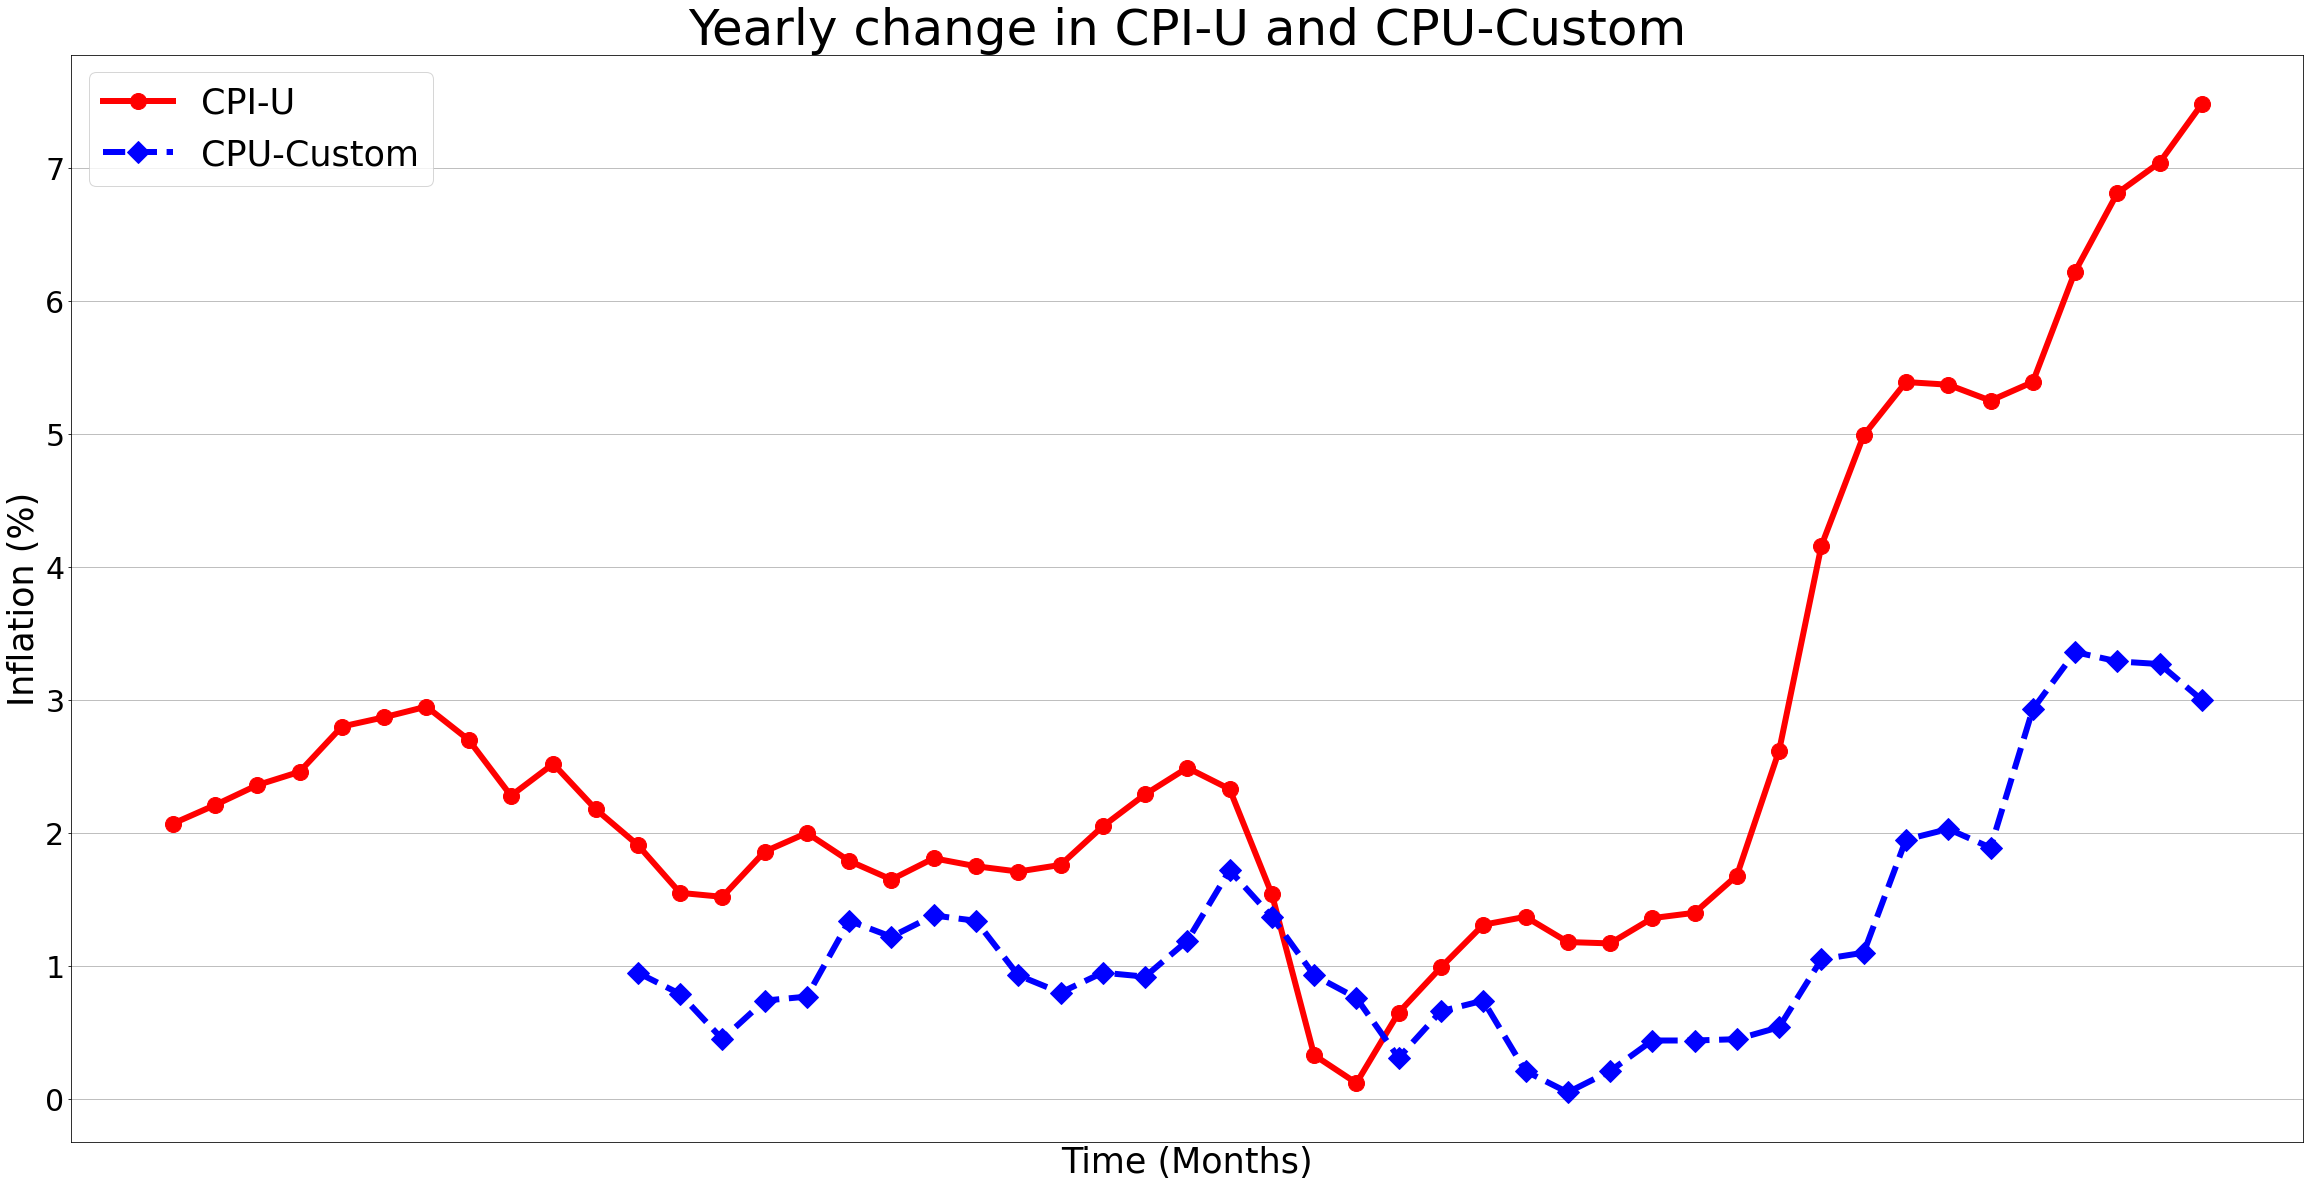

In [9]:
CPI_U = list(data3['CUUR0000SA0'])
CPI_C = list(data3['New_CPI'])
CPI_U.reverse()
CPI_C.reverse()
plt.figure(figsize=(40,20))
plt.plot(data3['t'], CPI_U, color='red', marker='o', markersize=16,  linestyle='-', linewidth=6, label = 'CPI-U')
plt.plot(data3['t'], CPI_C, color='blue', marker='D', markersize=16, linestyle='--', linewidth=6, label = 'CPU-Custom')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.grid(True)
plt.yticks(fontsize=30)
plt.title("Yearly change in CPI-U and CPU-Custom", fontsize=50)
plt.xlabel("Time (Months)", fontsize=35)
plt.ylabel("Inflation (%)", fontsize=35)
plt.legend(loc=2, prop={'size': 35})
plt.show()

### Results

## 6 Format
The group project should be in a Jupyter notebook that includes the answers and analysis listed above. I’m not looking for anything fancy but the following guidelines should be followed:
- Markdown should be used to create titles and to write your verbal answers to the questions.
- The names of the group members should appear at the top of the notebook.
- All variables and functions should have meaningful names (I know this is a subjective term).
- All code should be clearly and meaningfully commented, especially functions!

## 7 Grading Criteria
The project overall will be taken into account when a grade is determined. The following elements will be taken into account (including but not limited to...)
- How well explained is the process of constructing the index,
- Solving data problems (e.g. missing series, series which are not in a monthly frequency),
- Documenting the code in a clear way,
- The overall organization of the notebook,
- The discussion following the results on inflation.